Julia

Comenzaremos usando Julia y lo primero que haremos será importar los paquetes necesarios para que funcione el programa.

In [ ]:
import Pkg;
Pkg.add("DeconvOptim")
Pkg.add("TestImages")
Pkg.add("Colors")
Pkg.add("ImageIO")
Pkg.add("Noise")
Pkg.add("ImageShow")
Pkg.add("Images")
Pkg.add("FFTW")
Pkg.add("Plots")
Pkg.add("BenchmarkTools")
Pkg.add("Revise")
Pkg.add("ImageView")
Pkg.add("OffsetArrays")

Una vez importados los paquetes lo que hemos hecho ha sido coger una imagen de prueba, añadirla borrosidad y ruido y hacer la deconvolución en 2D sin regularizar.
Usaremos la misma PSF para el código en python y el mismo número de iteraciones.

In [11]:
using DeconvOptim, TestImages, Colors, ImageIO, Noise, ImageShow, Images, Plots, BenchmarkTools

# Cargar la imagen de prueba
img = load("ImagenPrueba.jpg")
img = Float32.(img)

# Generar la PSF (Point Spread Function)
psf = Float32.(generate_psf(size(img), 30))

# Crear una versión borrosa y ruidosa de la imagen
img_b = conv(img, psf)  # Imagen borrosa
img_n = poisson(img_b, 300)  # Imagen borrosa y ruidosa

# Guardar la imagen borrosa y ruidosa
save("blurrednoisy_img.jpg", img_b)

# Deconvolución 2D sin regularizador
res_no_reg, o = deconvolution(img_n, psf, regularizer=nothing, iterations=30)

# Medir el tiempo de ejecución de la deconvolución
@benchmark res_no_reg, o = deconvolution(img_n, psf, regularizer=nothing, iterations=30)





BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  220.325 ms … 386.142 ms  ┊ GC (min … max):  0.37% … 41.61%
 Time  (median):     226.733 ms               ┊ GC (median):     1.34%
 Time  (mean ± σ):   250.780 ms ±  58.190 ms  ┊ GC (mean ± σ):  11.07% ± 14.69%

  ▃ █                                                            
  █▄█▁▁▆▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  220 ms           Histogram: frequency by time          386 ms <

 Memory estimate: 172.58 MiB, allocs estimate: 5827.

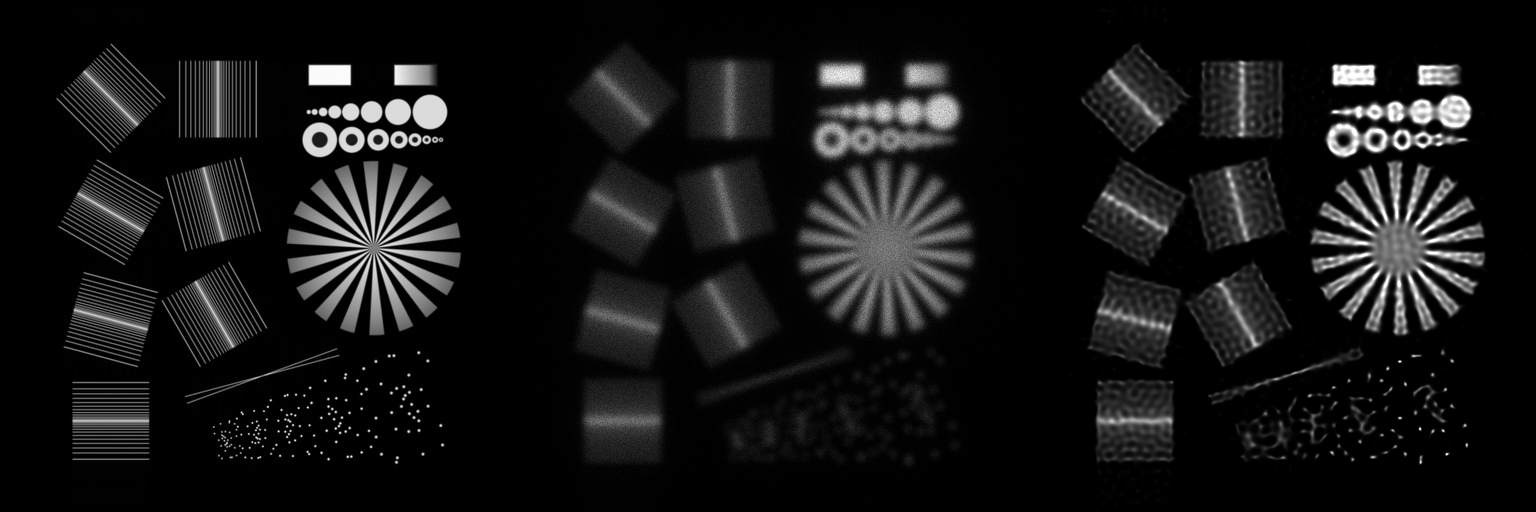

In [12]:
# Mostrar los resultados finales junto a la versión original y la versión borrosa
Gray.([img img_n res_no_reg])

ifftshift: Es una función utilizada en el contexto de transformadas de Fourier inversas (inversa de la Transformada de Fourier Discreta, DFT por sus siglas en inglés). Esta función reordena los elementos de un array de manera que el centro del arreglo (frecuencia cero) se desplace al inicio del array. Esto es crucial para asegurar que al realizar la inversa de una DFT, el resultado esté centrado de manera adecuada.

En nuestro caso la función de Julia generate_psf() genera una PSF la cual quedan las diagonales intercambiadas, si queremos guardar la PSF centrada tenemos que usar la función ifftshift

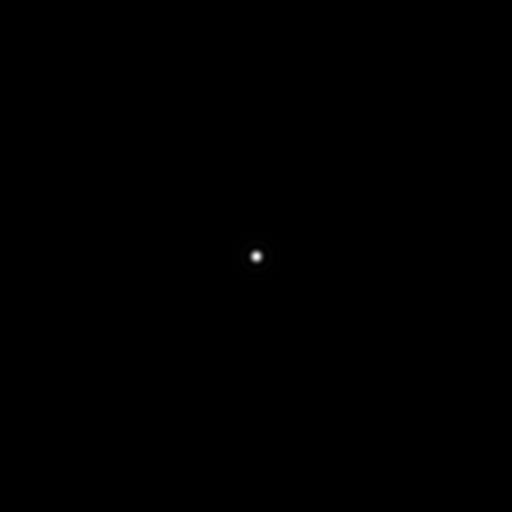

In [5]:
using FFTW, ImageIO, Colors, Images

# Suponemos que psf ya está definida
# Normaliza los valores de la PSF al rango [0, 1]
psf_min = minimum(psf)
psf_max = maximum(psf)
psf_normalized = (psf .- psf_min) ./ (psf_max - psf_min)
psf_gray = Gray.(psf_normalized)  # Convertir a escala de grises

# Centrar la PSF utilizando ifftshift
centered_psf = ifftshift(psf_normalized)
centered_psf_gray = Gray.(centered_psf)  # Convertir a escala de grises

# Guardar la PSF normalizada como una imagen JPEG
save("psf.jpg", centered_psf_gray)

# Mostrar la PSF centrada
display(centered_psf_gray)


Ahora vamos a usar la función richardson_lucy_iterative del módulo deconvoptim.jl sin regularización.

In [7]:
# Deconvolución iterativa de Richardson-Lucy sin regularizador
restored_img = richardson_lucy_iterative(img_n, psf; regularizer=nothing, iterations=30)
@benchmark restored_img = richardson_lucy_iterative(img_n, psf; regularizer=nothing, iterations=30)
#@benchmark sort(data) setup=(data=rand(10))


BenchmarkTools.Trial: 84 samples with 1 evaluation.
 Range (min … max):  58.939 ms …  63.027 ms  ┊ GC (min … max): 0.00% … 5.88%
 Time  (median):     59.362 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   59.626 ms ± 806.714 μs  ┊ GC (mean ± σ):  0.34% ± 1.09%

       █▇▃                                                      
  ▄▅█▆▇███▆▄▃▆▆▅▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▄▁▁▃▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▃ ▁
  58.9 ms         Histogram: frequency by time         62.8 ms <

 Memory estimate: 7.01 MiB, allocs estimate: 33.

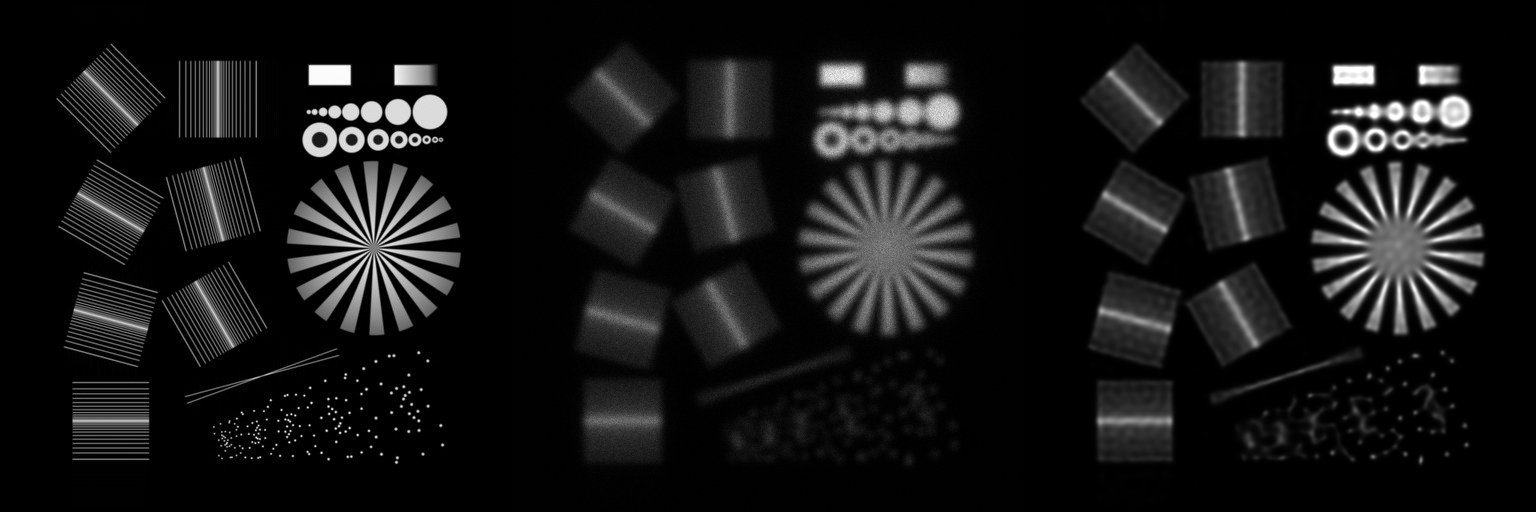

In [8]:
Gray.([img img_n restored_img])

Veremos ahora ejemplos con TV regularization en Julia

In [9]:
# Deconvolución iterativa de Richardson-Lucy con regularizador
optim_res = richardson_lucy_iterative(img_n, psf, λ=0.05, regularizer=TV(), iterations=20)
@benchmark optim_res = richardson_lucy_iterative(img_n, psf, λ=0.05, regularizer=TV(), iterations=20)


BenchmarkTools.Trial: 19 samples with 1 evaluation.
 Range (min … max):  265.582 ms … 281.440 ms  ┊ GC (min … max): 0.00% … 5.13%
 Time  (median):     273.026 ms               ┊ GC (median):    2.46%
 Time  (mean ± σ):   273.465 ms ±   4.191 ms  ┊ GC (mean ± σ):  2.40% ± 1.27%

                           ▃▃ █                                  
  ▇▁▇▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▇█▇▇▁▁▁▁▁▁▇▁▁▁▁▁▇▇▁▁▇▁▁▁▁▁▁▁▁▇▁▁▁▇ ▁
  266 ms           Histogram: frequency by time          281 ms <

 Memory estimate: 66.53 MiB, allocs estimate: 631390.

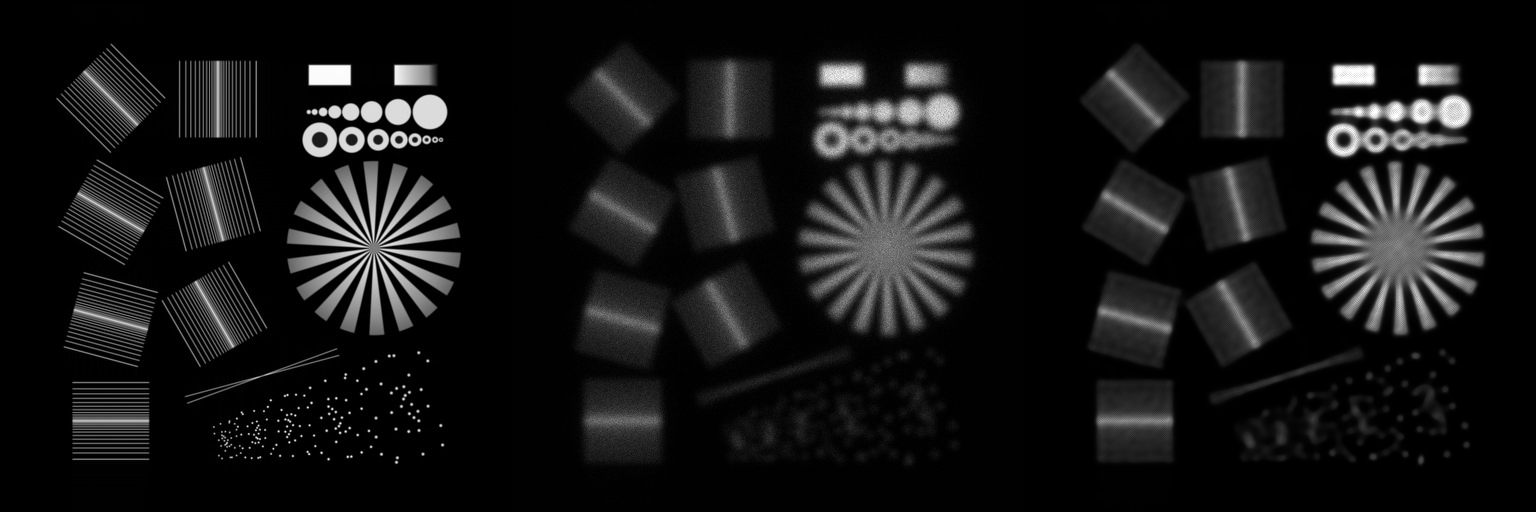

In [10]:
Gray.([img img_n optim_res])

Python

In [ ]:
pip install numpy matplotlib scipy scikit-image imageio

789 ms ± 1.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


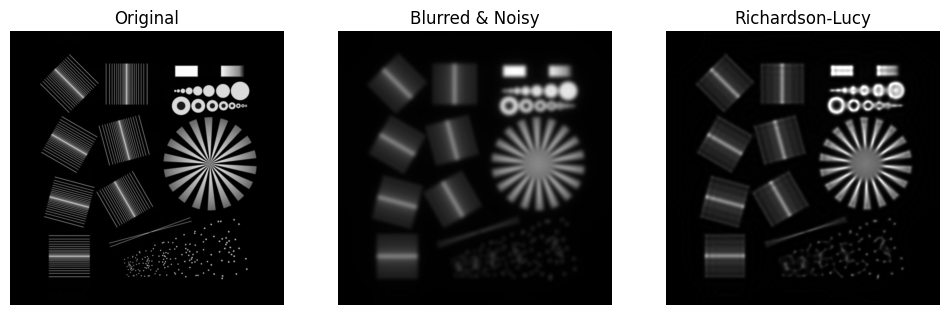

In [8]:
import numpy as np
from skimage import img_as_float
from skimage.restoration import richardson_lucy
import matplotlib.pyplot as plt
import imageio.v2 as iio

# Cargar las imágenes
img = img_as_float(iio.imread("ImagenPrueba.jpg"))
psf = img_as_float(iio.imread("psf.jpg"))
img_n = img_as_float(iio.imread("blurrednoisy_img.jpg"))

# Deconvolución de la imagen usando el algoritmo de Richardson-Lucy
res = richardson_lucy(img_n, psf, num_iter=30)
%timeit richardson_lucy(img_n, psf, num_iter=30)
# Mostrar las imágenes original, borrosa y deconvolucionada
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')  # Ocultar los ejes para una mejor visualización

plt.subplot(1, 3, 2)
plt.imshow(img_n, cmap='gray')
plt.title('Blurred & Noisy')
plt.axis('off')  # Ocultar los ejes para una mejor visualización

plt.subplot(1, 3, 3)
plt.imshow(res, cmap='gray')
plt.title('Richardson-Lucy')
plt.axis('off')  # Ocultar los ejes para una mejor visualización

plt.show()


Medimos ahora el tiempo de la función richardson_lucy()

In [9]:
%timeit richardson_lucy(img_n, psf, num_iter=30)

794 ms ± 8.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


JULIA EN 3D

In [1]:
using Revise, DeconvOptim, TestImages, Images, FFTW, Noise, ImageView, OffsetArrays

img = convert(Array{Float32}, channelview(load("Stack_1.tif")))
psf = ifftshift(convert(Array{Float32}, channelview(load("PSF.tif"))))
psf ./= sum(psf)

# create a blurred, noisy version of that image
img_b = conv(img, psf, [1, 2, 3])
img_n = poisson(img_b, 300);

#Regularizadores

reg1 = TV(num_dims=3, sum_dims=[1, 2, 3])
reg2 = Tikhonov(num_dims=3, sum_dims=[1, 2, 3], mode="identity")

#Deconvoluciones

@time res, ores = deconvolution(img, psf, regularizer=reg1, loss=Poisson(),
                          λ=0.05, padding=0.2, iterations=20);
@time res2, ores = deconvolution(img, psf, regularizer=reg2, loss=Poisson(),
                          λ=0.001, padding=0.0, iterations=20);

img_comb1 = [img[:, : ,32] res2[:, :, 32] res[:, :, 32] img_n[:, :, 32]]
img_comb2 = [img[:, : ,38] res2[:, :, 38] res[:, :, 38] img_n[:, :, 38]]
                          
img_comb = cat(img_comb1, img_comb2, dims=1)
img_comb ./= maximum(img_comb)
                          
imshow([img[:, :, 20:end] res2[:, :, 20:end] res[:, :, 20:end] img_n[:, :, 20:end]])
colorview(Gray, img_comb)
                          

BoundsError: BoundsError: attempt to access Tuple{Int64, Int64} at index [3]